In [2]:
import numpy as np
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import importlib.metadata 
from PIL import Image
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [3]:
print(tf.__version__)

2.19.0


In [28]:
!pip install kaggle

^C


In [21]:
!kaggle datasets download -d kaustubhb999/tomatoleaf -p C:\Users\eliza\.kaggle\

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0


In [4]:
!unzip C:\Users\eliza\.kaggle\tomatoleaf.zip -d C:\Users\eliza\.kaggle\tomatoleaf

^C


In [99]:
!ls C:\Users\eliza\.kaggle\tomatoleaf\tomato

train
val


cygwin warning:
  MS-DOS style path detected: C:\Users\eliza\.kaggle\tomatoleaf\tomato
  Preferred POSIX equivalent is: /cygdrive/c/Users/eliza/.kaggle/tomatoleaf/tomato
  CYGWIN environment variable option "nodosfilewarning" turns off this warning.
  Consult the user's guide for more details about POSIX paths:
    http://cygwin.com/cygwin-ug-net/using.html#using-pathnames


In [100]:
!ls C:\Users\eliza\.kaggle\tomatoleaf\tomato\train

Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___healthy


cygwin warning:
  MS-DOS style path detected: C:\Users\eliza\.kaggle\tomatoleaf\tomato\train
  Preferred POSIX equivalent is: /cygdrive/c/Users/eliza/.kaggle/tomatoleaf/tomato/train
  CYGWIN environment variable option "nodosfilewarning" turns off this warning.
  Consult the user's guide for more details about POSIX paths:
    http://cygwin.com/cygwin-ug-net/using.html#using-pathnames


In [101]:
!ls C:\Users\eliza\.kaggle\tomatoleaf\tomato\val

Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___healthy


cygwin warning:
  MS-DOS style path detected: C:\Users\eliza\.kaggle\tomatoleaf\tomato\val
  Preferred POSIX equivalent is: /cygdrive/c/Users/eliza/.kaggle/tomatoleaf/tomato/val
  CYGWIN environment variable option "nodosfilewarning" turns off this warning.
  Consult the user's guide for more details about POSIX paths:
    http://cygwin.com/cygwin-ug-net/using.html#using-pathnames


In [4]:
data_dir = pathlib.Path(r'C:\Users\eliza\.kaggle\tomatoleaf\tomato')

In [6]:
# tfds.list_builders()

## Data Preprocessing

In [5]:
batch_size = 32
img_height = 128
img_width = 128

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / 'train', 
    # validation_split = 0.3,
    # subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / 'val',
    # validation_split = 0.3,
    # subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [8]:
# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10,10))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(image_batch[i].numpy().astype('uint8'))
#     plt.title(class_names[label_batch[i]])
#     plt.axis('off')
# plt.show()

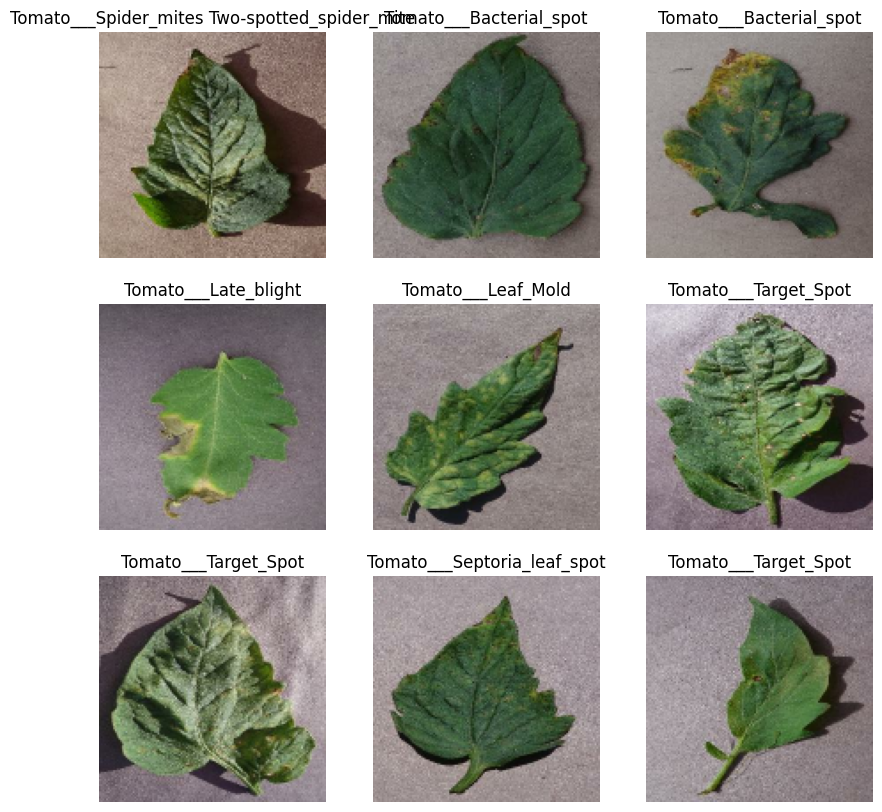

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1): # take 1 batch
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis('off')
plt.show()

### Normilizing

In [10]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(32, 128, 128, 3)
(32,)


In [11]:
normalization_layer = keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [12]:
train_ds = train_ds.map(lambda img, lab: (normalization_layer(img), lab))
val_ds = val_ds.map(lambda img, lab: (normalization_layer(img), lab))

In [13]:
# def normalization(dataset):
#     normalization_layer = tf.keras.layers.Rescaling(1./255)
#     return dataset.map(lambda img, lab: (normalization_layer(img), lab))

In [14]:
# train_ds = normalization(train_ds)
# val_ds = normalization(val_ds)

### One-hot Encoding

In [15]:
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=len(class_names))

In [16]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

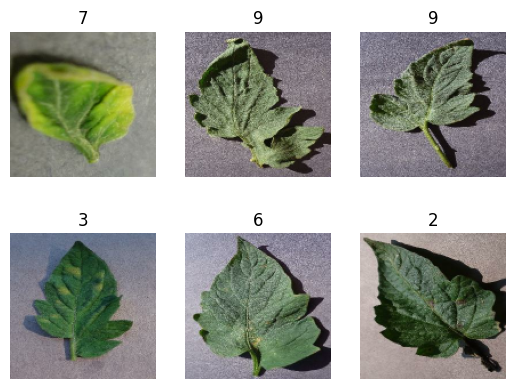

In [19]:
for img, label in train_ds.take(1):
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(img[i])
        plt.title(np.argmax(label[i], axis=-1))
        plt.axis('off')
plt.show()

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(factor=0.9),
    tf.keras.layers.RandomZoom(0.3)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0324517].


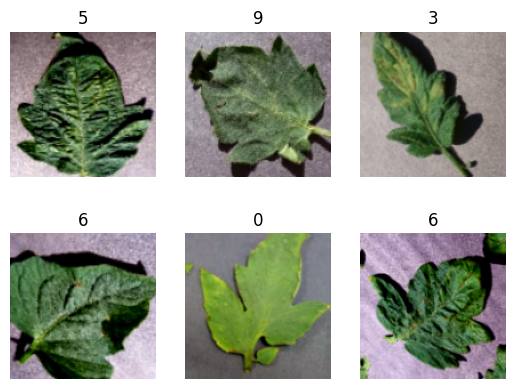

In [22]:
train_augm = train_ds.map(lambda x, y: (data_augmentation(x), y))

for img, label in train_augm.take(1):
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(img[i])
        plt.title(np.argmax(label[i], axis=-1))
        plt.axis('off')
plt.show()

In [37]:
# for img, label in train_ds.take(1):
#     plt.figure(figsize=(8, 6))
#     for i in range(6):
#         plt.subplot(2, 3, i+1)
#         plt.imshow(data_augmentation(img[i]))
#         plt.title(np.argmax(label[i]))
#         plt.axis('off')
# plt.show()

### Configute the dataset for performance

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Model

In [23]:
class CNN_Model():
    def __init__(self):
        pass
        
    def compile(self, model, optimizer):
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # CategoricalCrossentropy as we did label one-hot encoding
            metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'), 
                     tf.keras.metrics.Recall(name='recall'), 
                     tf.keras.metrics.AUC(name='auc'), 
                     tf.keras.metrics.F1Score(name='f1_score', average='micro')]
        ) 
        return model

    def train(self, model, train_set, valid_set, callbacks=None, epochs=15):
        callbacks = callbacks if callbacks is not None else []
        history = model.fit(    
            train_set, 
            validation_data = valid_set, 
            epochs=epochs, 
            callbacks=callbacks
        )    
        print(model.summary())
        return history
        
    def metrics_performance(self, history):
        metrics = {
            'Epoch': list(range(1, len(history.history['accuracy']) + 1)),
            'Train Accuracy':history.history['accuracy'],
            'Val Accuracy':history.history['val_accuracy'],
            'Train Loss': history.history['loss'],
            'Val Loss': history.history['val_loss'],
            'Train Precision': history.history['precision'],
            'Val Precision': history.history['val_precision'],
            'Train Recall': history.history['recall'],
            'Val Recall': history.history['val_recall'],
            'Train F1-score': history.history['f1_score'],
            'Val F1-score': history.history['val_f1_score'],
            'Train AUC': history.history['auc'],
            'Val AUC': history.history['val_auc']
        }
        # metrics_df = pd.DataFrame(metrics)
        return pd.DataFrame(metrics)

    def plot_performance(self, history):
        # loss 
        plt.figure()
        plt.plot(history.history['loss'], color='teal', label='loss')
        plt.plot(history.history['val_loss'], color='orange', label='val_loss')
        plt.title('Loss', fontsize=20)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        
        # accuracy
        plt.figure()
        plt.plot(history.history['accuracy'], color='teal', label='accuracy')
        plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
        plt.title('Accuracy', fontsize=20)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.show()
        
    def evaluate(self, model, test_set):
        loss, accuracy, precision, recall, auc, f1 = model.evaluate(test_set)
        print(f"\n|Accuracy: {accuracy}\n|Loss: {loss}\n|Precision: {precision}\n|Recall: {recall}\n|AUC: {auc}\n|F1: {f1}\n")
        return loss, accuracy, precision, recall, auc, f1

    def prediction(self, model, test_set):
        return np.argmax(model.predict(test_set), axis=-1)

In [24]:
cnn = CNN_Model()

### Basic Model
> - One convolutional layer


> - optimizer = 'adam'
> - callbacks = None

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.3918 - auc: 0.7631 - f1_score: 0.3918 - loss: 2.6860 - precision: 0.6033 - recall: 0.1778 - val_accuracy: 0.7520 - val_auc: 0.9585 - val_f1_score: 0.7520 - val_loss: 0.8249 - val_precision: 0.8495 - val_recall: 0.6380
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.7937 - auc: 0.9762 - f1_score: 0.7937 - loss: 0.6405 - precision: 0.8696 - recall: 0.7091 - val_accuracy: 0.7600 - val_auc: 0.9626 - val_f1_score: 0.7600 - val_loss: 0.7480 - val_precision: 0.8316 - val_recall: 0.7060
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.8817 - auc: 0.9912 - f1_score: 0.8817 - loss: 0.3828 - precision: 0.9223 - recall: 0.8398 - val_accuracy: 0.7980 - val_auc: 0.9708 - val_f1_score: 0.7980 - val_loss: 0.6557 - val_precision: 0.8390 - val_recall: 0.7660
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.9366 - auc: 0.9974 - f1_score: 0.9366 - loss: 0.2165 - precision: 0.9594 -

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 128)                 │      16,257,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,778,016 (186.07 MB)

 Trainable params: 16,259,338 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,518,678 (124.05 MB)

None


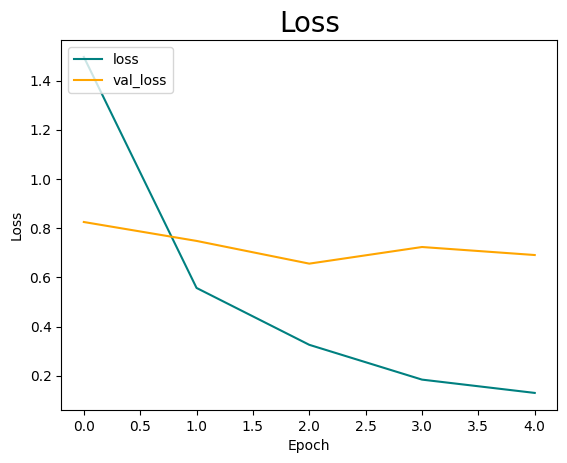

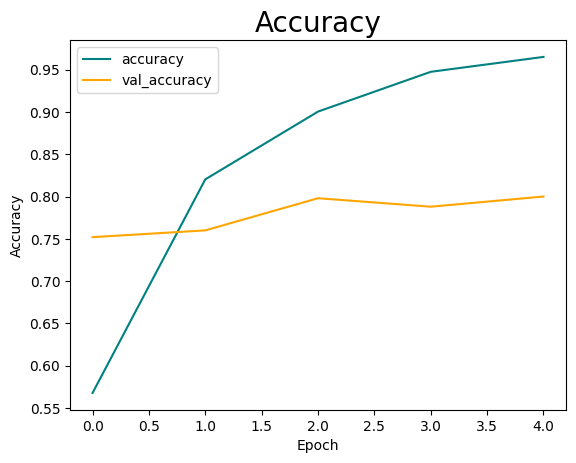

Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  Train Precision  \
0      1          0.5679         0.752    1.495942  0.824871         0.799050   
1      2          0.8203         0.760    0.556842  0.747988         0.883190   
2      3          0.9004         0.798    0.325648  0.655653         0.932255   
3      4          0.9474         0.788    0.184192  0.723220         0.965023   
4      5          0.9650         0.800    0.130099  0.690662         0.974477   

   Val Precision  Train Recall  Val Recall  Train F1-score  Val F1-score  \
0       0.849534        0.3702       0.638          0.5679         0.752   
1       0.831567        0.7508       0.706          0.8203         0.760   
2       0.838992        0.8642       0.766          0.9004         0.798   
3       0.823529        0.9298       0.770          0.9474         0.788   
4       0.824948        0.9545       0.787          0.9650         0.800   

   Train AUC   Val AUC  
0   0.890631  0.958454  
1   0.981819  0.962612  
2   0.993732  0.970806  
3   0.998189  0.968214  
4   0.999036  0.967592

In [69]:
# build the model
model_basic = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])

#compile model
model_basic = cnn.compile(model_basic, 'adam')

#train model
history_basic = cnn.train(model_basic, train_ds, val_ds, None, epochs=5)

# result analysis
cnn.plot_performance(history_basic)
metrics_df = cnn.metrics_performance(history_basic)
metrics_df

**Results for Basic Model:**
> - overfitting 
> - law accuracy

## Tuning

### Test 1
Firstly, I will try to enhance the basic model's performance by adding the hyperparamenters padding and strides.
>  
> - padding = ['same', 'valid']
> - strides = [1, 2]


|padding = same
|strides = 1

Epoch 1/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.4039 - auc: 0.7532 - f1_score: 0.4039 - loss: 2.9873 - precision: 0.5396 - recall: 0.2016 - val_accuracy: 0.7700 - val_auc: 0.9702 - val_f1_score: 0.7700 - val_loss: 0.7138 - val_precision: 0.8514 - val_recall: 0.6760
Epoch 2/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - accuracy: 0.8141 - auc: 0.9817 - f1_score: 0.8141 - loss: 0.5644 - precision: 0.8745 - recall: 0.7459 - val_accuracy: 0.7930 - val_auc: 0.9708 - val_f1_score: 0.7930 - val_loss: 0.6601 - val_precision: 0.8555 - val_recall: 0.7460
Epoch 3/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.9065 - auc: 0.9940 - f1_score: 0.9065 - loss: 0.3163 - precision: 0.9346 - recall: 0.8704 - val_accuracy: 0.8360 - val_auc: 0.9770 - val_f1_score: 0.8360 - val_loss: 0.5494 - val_precision: 0.8795 - val_recall: 0.8030
Epoch 4/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - accuracy: 0.9417 - auc: 0.9979 - f1_score: 0.9417 -

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,338,592 (192.03 MB)

 Trainable params: 16,779,530 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,559,062 (128.02 MB)

None


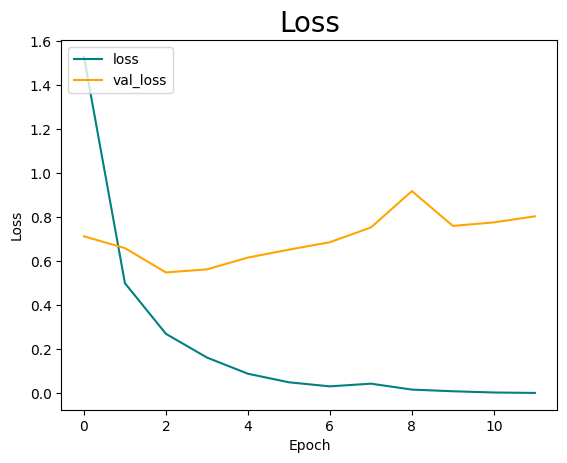

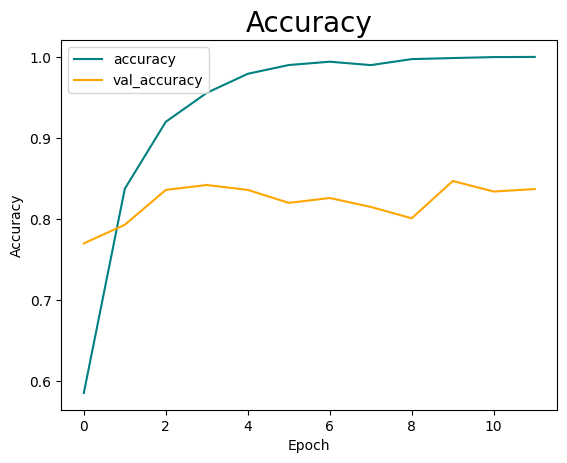

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
11     12             1.0         0.837    0.001774  0.804599   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
11              1.0       0.843813           1.0       0.832             1.0   

    Val F1-score  Train AUC   Val AUC  
11         0.837        1.0  0.964098  

|padding = same
|strides = 2

Epoch 1/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.3697 - auc: 0.7534 - f1_score: 0.3697 - loss: 1.9184 - precision: 0.6404 - recall: 0.1274 - val_accuracy: 0.6930 - val_auc: 0.9570 - val_f1_score: 0.6930 - val_loss: 0.8824 - val_precision: 0.8162 - val_recall: 0.5550
Epoch 2/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.7728 - auc: 0.9715 - f1_score: 0.7728 - loss: 0.7150 - precision: 0.8679 - recall: 0.6594 - val_accuracy: 0.7770 - val_auc: 0.9691 - val_f1_score: 0.7770 - val_loss: 0.6965 - val_precision: 0.8426 - val_recall: 0.6960
Epoch 3/12
313/313 ━━━━━━

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,589,856 (48.03 MB)

 Trainable params: 4,196,618 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,393,238 (32.02 MB)

None


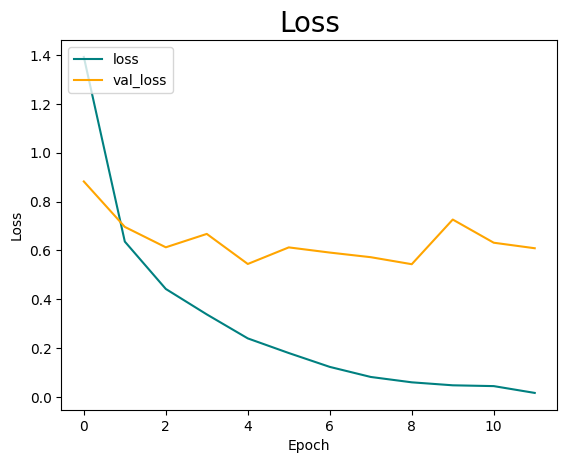

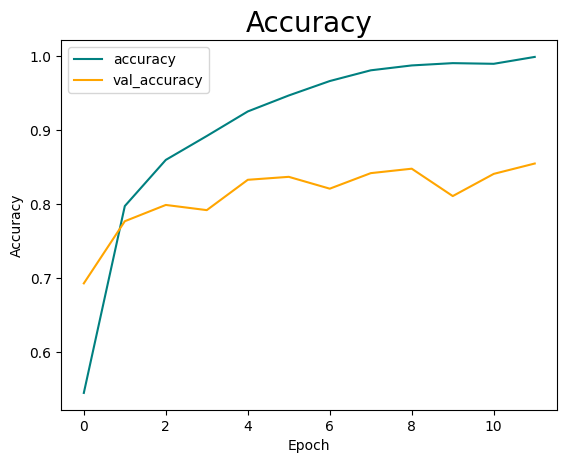

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
11     12          0.9991         0.855    0.017385  0.609205   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
11           0.9994       0.862385         0.999       0.846          0.9991   

    Val F1-score  Train AUC  Val AUC  
11         0.855   0.999992  0.97362  

|padding = valid
|strides = 1

Epoch 1/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 245ms/step - accuracy: 0.3918 - auc: 0.7588 - f1_score: 0.3918 - loss: 2.6977 - precision: 0.5860 - recall: 0.2011 - val_accuracy: 0.7490 - val_auc: 0.9653 - val_f1_score: 0.7490 - val_loss: 0.7789 - val_precision: 0.8539 - val_recall: 0.6370
Epoch 2/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 245ms/step - accuracy: 0.8009 - auc: 0.9769 - f1_score: 0.8009 - loss: 0.6350 - precision: 0.8724 - recall: 0.7073 - val_accuracy: 0.7910 - val_auc: 0.9692 - val_f1_score: 0.7910 - val_loss: 0.6884 - val_precision: 0.8523 - val_recall: 0.7270
Epoch 3/12
313/313 ━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      16,257,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,778,016 (186.07 MB)

 Trainable params: 16,259,338 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,518,678 (124.05 MB)

None


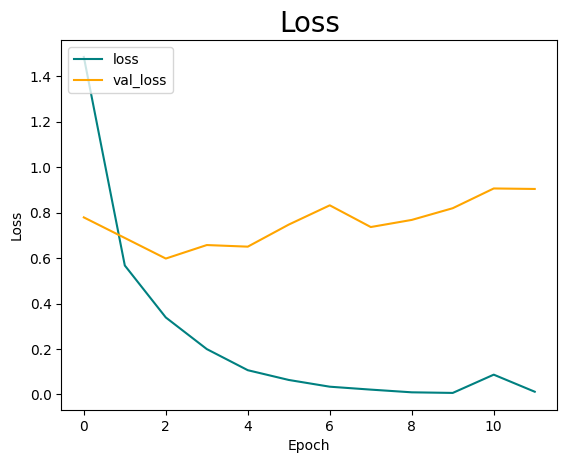

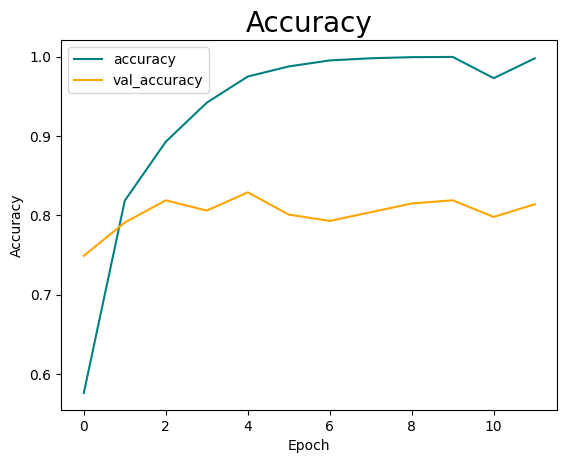

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
11     12           0.998         0.814    0.011823  0.903984   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
11         0.998099       0.821138        0.9977       0.808           0.998   

    Val F1-score  Train AUC  Val AUC  
11         0.814   0.999998  0.95638  

|padding = valid
|strides = 2

Epoch 1/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.3713 - auc: 0.7636 - f1_score: 0.3713 - loss: 1.9913 - precision: 0.6149 - recall: 0.1490 - val_accuracy: 0.6870 - val_auc: 0.9479 - val_f1_score: 0.6870 - val_loss: 0.9522 - val_precision: 0.8027 - val_recall: 0.5370
Epoch 2/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.7651 - auc: 0.9701 - f1_score: 0.7651 - loss: 0.7299 - precision: 0.8586 - recall: 0.6528 - val_accuracy: 0.6880 - val_auc: 0.9564 - val_f1_score: 0.6880 - val_loss: 0.8652 - val_precision: 0.7604 - val_recall: 0.6030
Epoch 3/12
313/313 ━━━━━━━

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,936,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,815,712 (45.07 MB)

 Trainable params: 3,938,570 (15.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,877,142 (30.05 MB)

None


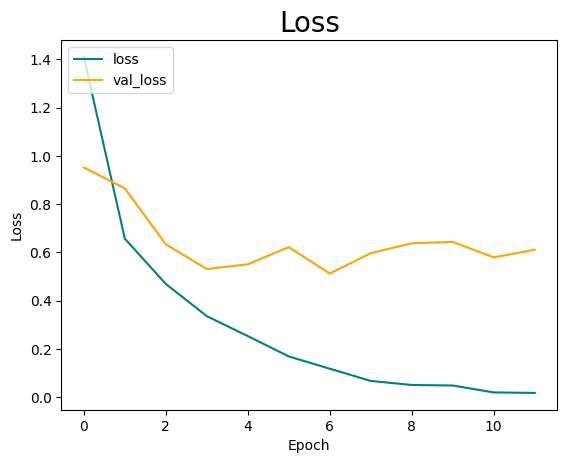

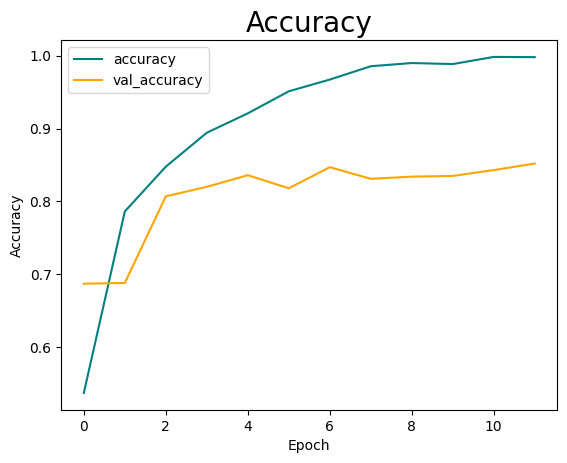

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
11     12          0.9981         0.852    0.016947  0.610599   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
11         0.998299       0.864476        0.9977       0.842          0.9981   

    Val F1-score  Train AUC   Val AUC  
11         0.852   0.999994  0.974029  


In [16]:
for padding in ['same', 'valid']:
    for strides in [1, 2]:
        print(f'\n|padding = {padding}\n|strides = {strides}\n')
        model_basic = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), padding=padding, strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
        ])
                
        model_basic = cnn.compile(model_basic, 'adam')          #compile model
        history_basic = cnn.train(model_basic, train_ds, val_ds, None, epochs=12)   #train model
        cnn.plot_performance(history_basic)          
        metrics_df = cnn.metrics_performance(history_basic)       # results
        print(metrics_df.iloc[-1:])           

>**Results in the last epoch:** 
>
> **padding = same, strides = 1**
> - train accuracy: 100%, val accuracy: 83%
> - loss: 0.80
> - precision: 0.84
> - recall: 0.83
> - f1_score: 0.83
> - auc: 0.96
>
> **padding = same, strides = 2**
> - train accuracy: 99%, val accuracy: 85%
> - loss: 0.60
> - precision: 0.86
> - recall: 0.84
> - f1_score: 0.85
> - auc: 0.97
>
>  **padding = valid, strides = 1**
> - train accuracy: 99%, val accuracy: 81%
> - loss: 0.90
> - precision: 0.82
> - recall: 0.88
> - f1_score: 0.81
> - auc: 0.95
>
> **padding = valid, strides = 2**
> - train accuracy: 99%, val accuracy: 85%
> - loss: 0.61
> - precision: 0.86
> - recall: 0.84
> - f1_score: 0.85
> - auc: 0.97

Regarding results, the value for the hyperparameter strides = 2 improved the model's performance, with the accuracy of the validation set being by 4% higher than with strides = 2.
If talking about padding, metrics reached similar results. However, curves of the validation set was more stable with the padding = valid.

**Following these, my next models will be tuned with the next hyperparameters:**
- strides = 2
- padding = valid

Additionally, since model have an overfitting problem, the most appropriate solution is the implimentation of the regularization layers (dropout, batch normalization) to the models.

### Test 2

> **Model 1:**
> - Two Conv2D layers
> - BatchNorm layers
> - Dropout Layer (0.25 for hidden, 0.4 after flatten)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 238ms/step - accuracy: 0.6748 - auc: 0.9303 - f1_score: 0.6748 - loss: 1.0185 - precision: 0.8171 - recall: 0.5293 - val_accuracy: 0.1130 - val_auc: 0.5494 - val_f1_score: 0.1130 - val_loss: 6.3935 - val_precision: 0.1145 - val_recall: 0.1130
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 229ms/step - accuracy: 0.8955 - auc: 0.9934 - f1_score: 0.8955 - loss: 0.3340 - precision: 0.9319 - recall: 0.8588 - val_accuracy: 0.3440 - val_auc: 0.7954 - val_f1_score: 0.3440 - val_loss: 2.9198 - val_precision: 0.3547 - val_recall: 0.3380
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 229ms/step - accuracy: 0.9346 - auc: 0.9977 - f1_score: 0.9346 - loss: 0.2113 - precision: 0.9510 - recall: 0.9132 - val_accuracy: 0.7120 - val_auc: 0.9491 - val_f1_score: 0.7120 - val_loss: 0.9818 - val_precision: 0.7436 - val_recall: 0.6700
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 238ms/step - accuracy: 0.9627 - auc: 0.9989 - f1_score: 0.9627 - loss: 0.1362 - precision: 0.96

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,681,760 (90.34 MB)

 Trainable params: 7,893,770 (30.11 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 15,787,542 (60.22 MB)

None


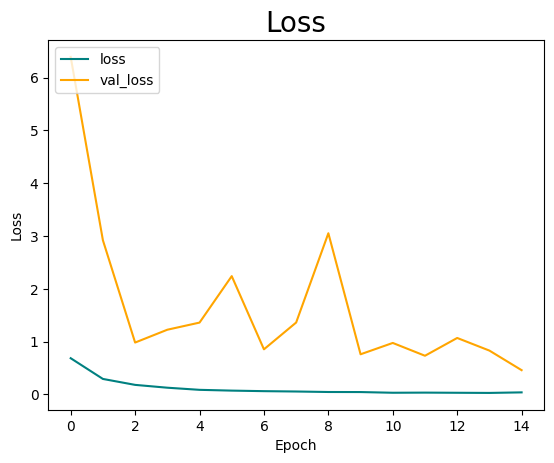

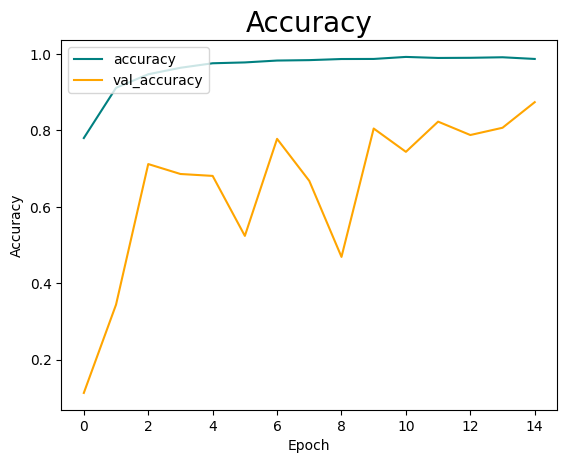

Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
0       1          0.7801         0.113    0.684999  6.393539   
1       2          0.9115         0.344    0.292374  2.919785   
2       3          0.9470         0.712    0.179899  0.981847   
3       4          0.9640         0.686    0.126295  1.224799   
4       5          0.9758         0.681    0.086004  1.359998   
5       6          0.9780         0.524    0.071200  2.240284   
6       7          0.9829         0.778    0.060926  0.853396   
7       8          0.9840         0.668    0.054374  1.361411   
8       9          0.9869         0.469    0.045003  3.052613   
9      10          0.9871         0.805    0.043821  0.759550   
10     11          0.9924         0.744    0.030748  0.974380   
11     12          0.9897         0.823    0.033226  0.731751   
12     13          0.9901         0.788    0.030293  1.068732   
13     14          0.9915         0.807    0.027492  0.829624   
14     15          0.9871         0.874    0.037888  0.458591   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
0          0.878605       0.114488        0.6825       0.113          0.7801   
1          0.939303       0.354669        0.8790       0.338          0.9115   
2          0.960438       0.743618        0.9298       0.670          0.9470   
3          0.970263       0.707974        0.9560       0.657          0.9640   
4          0.980699       0.707447        0.9705       0.665          0.9758   
5          0.981174       0.536481        0.9746       0.500          0.9780   
6          0.985031       0.800839        0.9805       0.764          0.9829   
7          0.985842       0.689947        0.9818       0.652          0.9840   
8          0.988565       0.485804        0.9855       0.462          0.9869   
9          0.988071       0.826042        0.9857       0.793          0.9871   
10         0.993386       0.759336        0.9913       0.732          0.9924   
11         0.990483       0.829615        0.9887       0.818          0.9897   
12         0.991382       0.798156        0.9893       0.779          0.9901   
13         0.992490       0.822199        0.9912       0.800          0.9915   
14         0.988181       0.882653        0.9866       0.865          0.9871   

    Val F1-score  Train AUC   Val AUC  
0          0.113   0.973727  0.549355  
1          0.344   0.995139  0.795422  
2          0.712   0.998285  0.949138  
3          0.686   0.999059  0.928743  
4          0.681   0.999688  0.926238  
5          0.524   0.999759  0.855049  
6          0.778   0.999806  0.960926  
7          0.668   0.999853  0.921896  
8          0.469   0.999803  0.828071  
9          0.805   0.999836  0.963569  
10         0.744   0.999954  0.950568  
11         0.823   0.999949  0.969311  
12         0.788   0.999951  0.950406  
13         0.807   0.999910  0.960837  
14         0.874   0.999808  0.980053

In [29]:
# build the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding = 'valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding = 'valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])

#compile model
model_1 = cnn.compile(model_1, 'adam')

#train model
history_m1 = cnn.train(model_1, train_ds, val_ds, None, epochs=15)

# result analysis
cnn.plot_performance(history_m1)
metrics_m1_df = cnn.metrics_performance(history_m1)
metrics_m1_df

**Results Model 1:**
> - overfitting 
> - accuracy increased
> - loss significantly decreased

>   **Epoch 10:**
> - train accuracy: 96%, val accuracy: 87%
> - loss: 0.45
> - precision: 0.88
> - recall: 0.86
> - f1_score: 0.87
> - auc: 0.98

Since the models remained with overfitting, I will impliment next changes:
1. add L2 regularization.
2. slightly decrease dropout
3. add callbacks
- EarlyStopping - training will be terminated if there is no improvement.
- ReduceLROnPlateau - for faster convergence of loss function and to avoid overshooting

###  Test 3

> **Model 2:**
> - Three Conv2D layers
> - BatchNorm layer
> - Dropout Layer (0.2, 0.3)
> - L2 regularization (l_r = 0.001)

In [27]:
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights =True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience=3, min_lr=0.00001)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - accuracy: 0.6305 - auc: 0.9216 - f1_score: 0.6305 - loss: 1.1926 - precision: 0.7901 - recall: 0.4952 - val_accuracy: 0.1070 - val_auc: 0.5661 - val_f1_score: 0.1070 - val_loss: 5.5695 - val_precision: 0.1073 - val_recall: 0.1040 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.8839 - auc: 0.9921 - f1_score: 0.8839 - loss: 0.4869 - precision: 0.9173 - recall: 0.8340 - val_accuracy: 0.3340 - val_auc: 0.8110 - val_f1_score: 0.3340 - val_loss: 2.6826 - val_precision: 0.3398 - val_recall: 0.3170 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.9046 - auc: 0.9958 - f1_score: 0.9046 - loss: 0.3704 - precision: 0.9296 - recall: 0.8808 - val_accuracy: 0.6080 - val_auc: 0.9071 - val_f1_score: 0.6080 - val_loss: 1.6074 - val_precision: 0.6337 - val_recall: 0.5760 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,705,120 (21.76 MB)

 Trainable params: 1,901,514 (7.25 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 3,803,030 (14.51 MB)

None


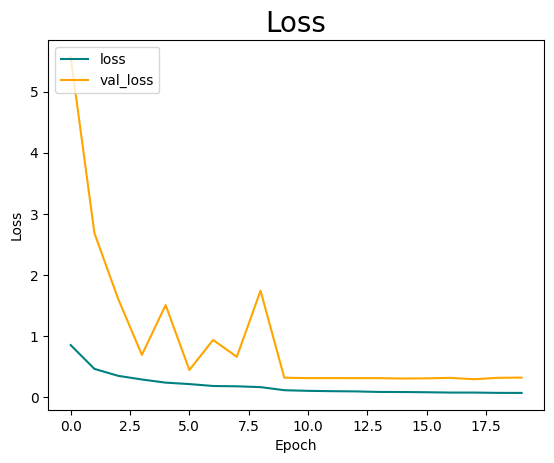

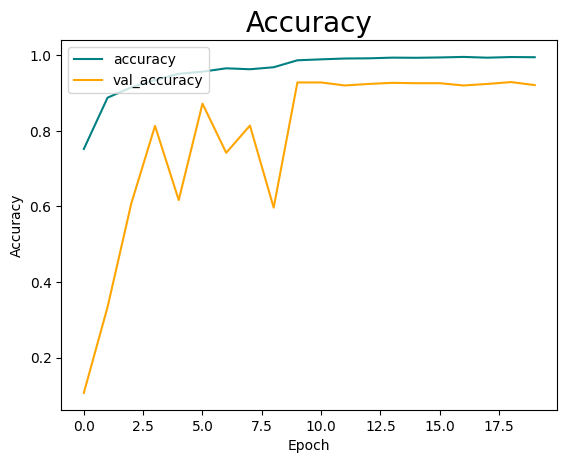

Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
0       1          0.7521         0.107    0.849591  5.569541   
1       2          0.8877         0.334    0.460071  2.682580   
2       3          0.9149         0.608    0.346534  1.607428   
3       4          0.9344         0.813    0.286442  0.689039   
4       5          0.9509         0.617    0.235075  1.505405   
5       6          0.9565         0.872    0.211436  0.442139   
6       7          0.9654         0.742    0.179957  0.934405   
7       8          0.9629         0.814    0.174885  0.657650   
8       9          0.9682         0.597    0.161515  1.741186   
9      10          0.9866         0.928    0.111056  0.316005   
10     11          0.9891         0.928    0.100550  0.308919   
11     12          0.9913         0.920    0.095180  0.309240   
12     13          0.9918         0.924    0.091367  0.308708   
13     14          0.9936         0.927    0.082712  0.308427   
14     15          0.9932         0.926    0.081190  0.302347   
15     16          0.9941         0.926    0.077489  0.305602   
16     17          0.9955         0.920    0.072385  0.312846   
17     18          0.9935         0.924    0.072251  0.291017   
18     19          0.9952         0.929    0.067392  0.313880   
19     20          0.9947         0.921    0.066527  0.317805   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
0          0.864025       0.107327        0.6564       0.104          0.7521   
1          0.920366       0.339764        0.8460       0.317          0.8877   
2          0.937717       0.633663        0.8928       0.576          0.9149   
3          0.950124       0.841202        0.9182       0.784          0.9344   
4          0.960969       0.639871        0.9405       0.597          0.9509   
5          0.963742       0.895616        0.9489       0.858          0.9565   
6          0.971220       0.776216        0.9584       0.718          0.9654   
7          0.968329       0.835774        0.9570       0.799          0.9629   
8          0.973208       0.614660        0.9626       0.587          0.9682   
9          0.988345       0.932118        0.9837       0.920          0.9866   
10         0.990965       0.931244        0.9871       0.921          0.9891   
11         0.992679       0.928862        0.9899       0.914          0.9913   
12         0.993180       0.933809        0.9903       0.917          0.9918   
13         0.994390       0.933063        0.9926       0.920          0.9936   
14         0.993890       0.927126        0.9922       0.916          0.9932   
15         0.995392       0.930894        0.9936       0.916          0.9941   
16         0.995995       0.933538        0.9948       0.913          0.9955   
17         0.994295       0.932118        0.9934       0.920          0.9935   
18         0.995596       0.931313        0.9946       0.922          0.9952   
19         0.994992       0.928065        0.9934       0.916          0.9947   

    Val F1-score  Train AUC   Val AUC  
0          0.107   0.969670  0.566094  
1          0.334   0.992789  0.810966  
2          0.608   0.996392  0.907133  
3          0.813   0.997660  0.976491  
4          0.617   0.998318  0.917005  
5          0.872   0.998806  0.989806  
6          0.742   0.999288  0.956601  
7          0.814   0.999355  0.976068  
8          0.597   0.999436  0.902530  
9          0.928   0.999906  0.991895  
10         0.928   0.999939  0.992622  
11         0.920   0.999891  0.992196  
12         0.924   0.999896  0.992004  
13         0.927   0.999976  0.991551  
14         0.926   0.999969  0.992298  
15         0.926   0.999975  0.992082  
16         0.920   0.999985  0.992474  
17         0.924   0.999977  0.992426  
18         0.929   0.999982  0.990654  
19         0.921   0.999979  0.989518

In [31]:
# build the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    
    tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding = 'valid',
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='valid', 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='valid', 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  
])

#compile model
model_2 = cnn.compile(model_2, 'adam')

#train model
# early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights =True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience=3, min_lr=0.00001)
history_m2 = cnn.train(model_2, train_ds, val_ds, [early_stoping, reduce_lr], epochs=20)    # changes

# result analysis
cnn.plot_performance(history_m2)

metrics_m2_df = cnn.metrics_performance(history_m2)
metrics_m2_df

> **Results Model 2:**
> - overfitting
> - accuracy significantly increased

>   **Epoch 10:**
> - train accuracy: 0.99, val accuracy: 0.92
> - loss: 0.31
> - precision: 0.92
> - recall: 0.91
> - f1_score: 0.92
> - auc: 0.98

Despite a good accuracy, the gab between training and validating set is hight, suggesting overfitting. Therefore, I will apply Data Augmentation, which will increase the performance, making the training images more diverse.

### Test 4

> **Model 3:**
> - Three Conv2D layers
> - Data Augmentation layers
> - BatchNorm layer
> - Dropout Layer (0.2)
> - L2 regularization (l_r = 0.001)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 212ms/step - accuracy: 0.3708 - auc: 0.7708 - f1_score: 0.3708 - loss: 2.1771 - precision: 0.5404 - recall: 0.1858 - val_accuracy: 0.4150 - val_auc: 0.8388 - val_f1_score: 0.4150 - val_loss: 1.7904 - val_precision: 0.5049 - val_recall: 0.3080 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.6764 - auc: 0.9506 - f1_score: 0.6764 - loss: 0.9406 - precision: 0.7646 - recall: 0.5849 - val_accuracy: 0.6400 - val_auc: 0.9282 - val_f1_score: 0.6400 - val_loss: 1.1998 - val_precision: 0.6931 - val_recall: 0.5940 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 213ms/step - accuracy: 0.7227 - auc: 0.9597 - f1_score: 0.7227 - loss: 0.8300 - precision: 0.7799 - recall: 0.6605 - val_accuracy: 0.7000 - val_auc: 0.9457 - val_f1_score: 0.7000 - val_loss: 1.0222 - val_precision: 0.7374 - val_recall: 0.6710 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128, 128, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,704,120 (21.76 MB)

 Trainable params: 1,901,264 (7.25 MB)

 Non-trainable params: 326 (1.27 KB)

 Optimizer params: 3,802,530 (14.51 MB)

None


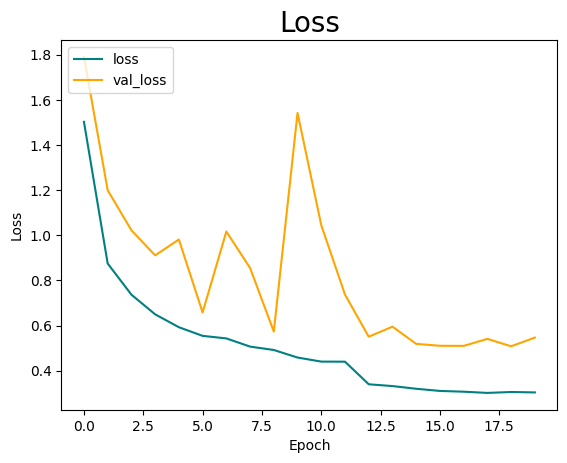

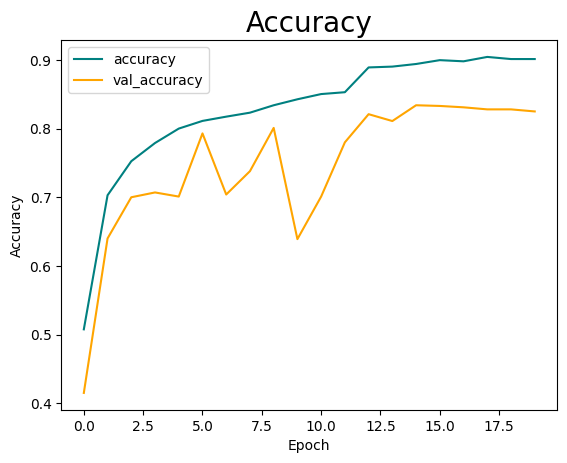

Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
0       1          0.5076         0.415    1.502746  1.790393   
1       2          0.7029         0.640    0.874905  1.199751   
2       3          0.7525         0.700    0.736847  1.022214   
3       4          0.7790         0.707    0.649718  0.910955   
4       5          0.8000         0.701    0.592585  0.981157   
5       6          0.8112         0.793    0.554296  0.658008   
6       7          0.8174         0.704    0.543003  1.016594   
7       8          0.8232         0.738    0.506693  0.855238   
8       9          0.8340         0.801    0.491687  0.573147   
9      10          0.8427         0.639    0.458278  1.542070   
10     11          0.8503         0.701    0.440181  1.044681   
11     12          0.8530         0.780    0.439851  0.737014   
12     13          0.8891         0.821    0.339775  0.550512   
13     14          0.8903         0.811    0.331795  0.595035   
14     15          0.8941         0.834    0.319866  0.518833   
15     16          0.8997         0.833    0.310239  0.510348   
16     17          0.8980         0.831    0.306860  0.509845   
17     18          0.9044         0.828    0.301436  0.540923   
18     19          0.9013         0.828    0.305569  0.508153   
19     20          0.9013         0.825    0.303626  0.546568   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
0          0.711421       0.504918        0.3370       0.308          0.5076   
1          0.781605       0.693116        0.6195       0.594          0.7029   
2          0.808738       0.737363        0.6960       0.671          0.7525   
3          0.827524       0.745335        0.7336       0.679          0.7790   
4          0.843333       0.733260        0.7590       0.668          0.8000   
5          0.847826       0.808059        0.7722       0.762          0.8112   
6          0.855009       0.722163        0.7843       0.681          0.8174   
7          0.858181       0.764894        0.7915       0.719          0.8232   
8          0.866027       0.827331        0.8035       0.781          0.8340   
9          0.873927       0.645161        0.8145       0.620          0.8427   
10         0.880529       0.718588        0.8262       0.692          0.8503   
11         0.879592       0.802521        0.8284       0.764          0.8530   
12         0.909062       0.836608        0.8697       0.809          0.8891   
13         0.912893       0.820803        0.8709       0.797          0.8903   
14         0.915146       0.855208        0.8779       0.821          0.8941   
15         0.919274       0.846392        0.8814       0.821          0.8997   
16         0.916962       0.845915        0.8801       0.818          0.8980   
17         0.922829       0.842916        0.8861       0.821          0.9044   
18         0.920378       0.848861        0.8866       0.820          0.9013   
19         0.919048       0.842324        0.8844       0.812          0.9013   

    Val F1-score  Train AUC   Val AUC  
0          0.415   0.876826  0.838751  
1          0.640   0.957012  0.928157  
2          0.700   0.968037  0.945677  
3          0.707   0.975188  0.955389  
4          0.701   0.979226  0.951620  
5          0.793   0.981912  0.972952  
6          0.704   0.982320  0.949324  
7          0.738   0.984785  0.959669  
8          0.801   0.985713  0.978672  
9          0.639   0.987466  0.910803  
10         0.701   0.988217  0.947928  
11         0.780   0.988329  0.968403  
12         0.821   0.992873  0.980382  
13         0.811   0.993669  0.979041  
14         0.834   0.993872  0.983034  
15         0.833   0.994617  0.983316  
16         0.831   0.994413  0.984130  
17         0.828   0.994700  0.980393  
18         0.828   0.994478  0.984815  
19         0.825   0.994545  0.979509

In [35]:
# build the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),

    # Augmentation
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, (3, 3),  padding='valid', strides = (2, 2), 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2),  
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2), 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  
])

#compile model
model_3 = cnn.compile(model_3, 'adam')

#train model
# early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights =True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience=3, min_lr=0.00001)
history_m3 = cnn.train(model_3, train_ds, val_ds, [early_stoping, reduce_lr], epochs=20)    # changes

# result analysis
cnn.plot_performance(history_m3)

metrics_m3_df = cnn.metrics_performance(history_m3)
metrics_m3_df

> **Results Model 3:**
> - performance deteriorated
> - remained with overfitting


>   **Epoch 10:**
> - train accuracy: 0.90, val accuracy: 0.82
> - loss: 0.54
> - precision: 0.84
> - recall: 0.81
> - f1_score: 0.82
> - auc: 0.97

### Test 5

Previously I have chosen 'adam' as an optimizer for the cnn model. 

For now, I will compare results with several optimizers: 
- SGD
- Adam
- RMSprop

In [65]:
optimizers = [
    keras.optimizers.RMSprop(),
    keras.optimizers.SGD(),
    tf.keras.optimizers.Adam()
]

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 200ms/step - accuracy: 0.3447 - auc: 0.7352 - f1_score: 0.3447 - loss: 2.7957 - precision: 0.5049 - recall: 0.1878 - val_accuracy: 0.2860 - val_auc: 0.7486 - val_f1_score: 0.2860 - val_loss: 3.3434 - val_precision: 0.3134 - val_recall: 0.2670 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 192ms/step - accuracy: 0.6819 - auc: 0.9506 - f1_score: 0.6819 - loss: 0.9433 - precision: 0.7683 - recall: 0.6019 - val_accuracy: 0.5750 - val_auc: 0.9032 - val_f1_score: 0.5750 - val_loss: 1.6017 - val_precision: 0.6020 - val_recall: 0.5490 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.7419 - auc: 0.9651 - f1_score: 0.7419 - loss: 0.7770 - precision: 0.7975 - recall: 0.6856 - val_accuracy: 0.7270 - val_auc: 0.9454 - val_f1_score: 0.7270 - val_loss: 1.0634 - val_precision: 0.7532 - val_recall: 0.7140 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 193ms/step - accuracy: 

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_10 (RandomRotation)  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_10 (RandomZoom)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 128, 128, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_39 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,802,856 (14.51 MB)

 Trainable params: 1,901,264 (7.25 MB)

 Non-trainable params: 326 (1.27 KB)

 Optimizer params: 1,901,266 (7.25 MB)

None


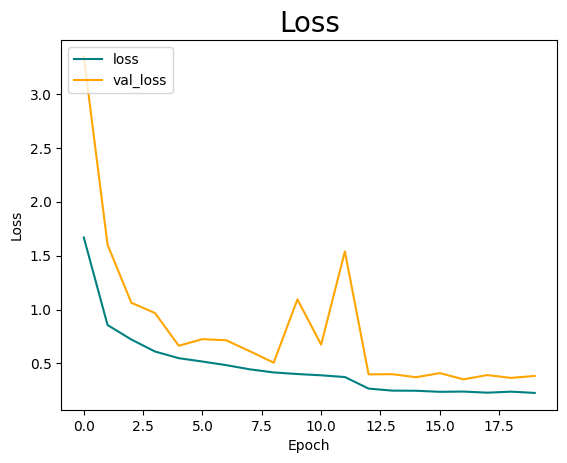

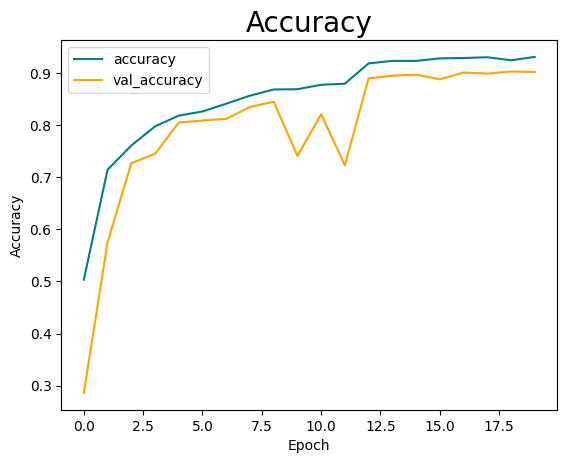

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
19     20           0.931         0.902    0.226833  0.384432   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
19         0.941699       0.904858        0.9223       0.894           0.931   

    Val F1-score  Train AUC   Val AUC  
19         0.902   0.996349  0.985645  
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 184ms/step - accuracy: 0.3876 - auc: 0.7902 - f1_score: 0.3876 - loss: 1.7817 - precision: 0.6156 - recall: 0.1938 - val_accuracy: 0.2500 - val_auc: 0.7687 - val_f1_score: 0.2500 - val_loss: 2.6885 - val_precision: 0.2808 - val_recall: 0.2300 - learning_rate: 0.0100
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.6992 - auc: 0.9595 - f1_score: 0.6992 - loss: 0.8495 - precision: 0.7867 - recall: 0.6055 - val_accuracy: 0.7220 - val_auc: 0.9583 - val_f1_score: 0.7220 - val_loss: 0.8480 - val_precision: 0.8037 - val_recall: 0.6510 - learning_rate: 0.0100
Epoch 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_11 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_11 (RandomRotation)  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_11 (RandomZoom)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 128, 128, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,901,592 (7.25 MB)

 Trainable params: 1,901,264 (7.25 MB)

 Non-trainable params: 326 (1.27 KB)

 Optimizer params: 2 (12.00 B)

None


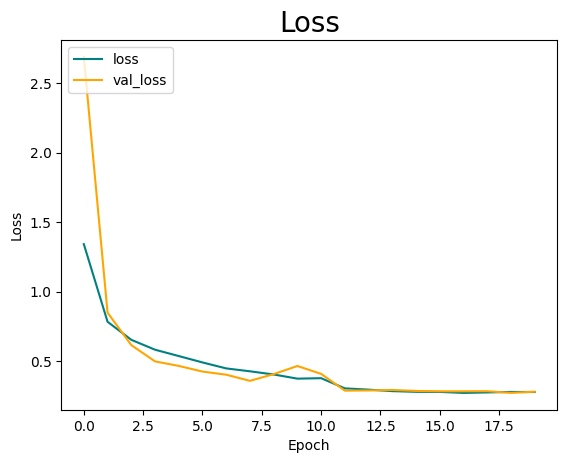

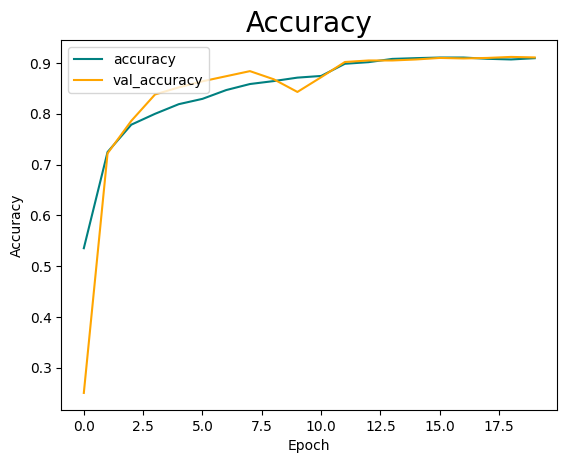

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
19     20          0.9095         0.911    0.276756  0.279245   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
19         0.926799       0.920327        0.8926       0.901          0.9095   

    Val F1-score  Train AUC   Val AUC  
19         0.911   0.994922  0.994083  
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 209ms/step - accuracy: 0.4420 - auc: 0.8179 - f1_score: 0.4420 - loss: 2.0093 - precision: 0.5743 - recall: 0.2860 - val_accuracy: 0.3230 - val_auc: 0.7715 - val_f1_score: 0.3230 - val_loss: 2.8802 - val_precision: 0.3486 - val_recall: 0.2970 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.7351 - auc: 0.9643 - f1_score: 0.7351 - loss: 0.7795 - precision: 0.7964 - recall: 0.6693 - val_accuracy: 0.7800 - val_auc: 0.9768 - val_f1_score: 0.7800 - val_loss: 0.6309 - val_precision: 0.8068 - val_recall: 0.7390 - learning_rate: 0.0010
Epoch 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_12 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_12 (RandomRotation)  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_12 (RandomZoom)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 128, 128, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 5,704,120 (21.76 MB)

 Trainable params: 1,901,264 (7.25 MB)

 Non-trainable params: 326 (1.27 KB)

 Optimizer params: 3,802,530 (14.51 MB)

None


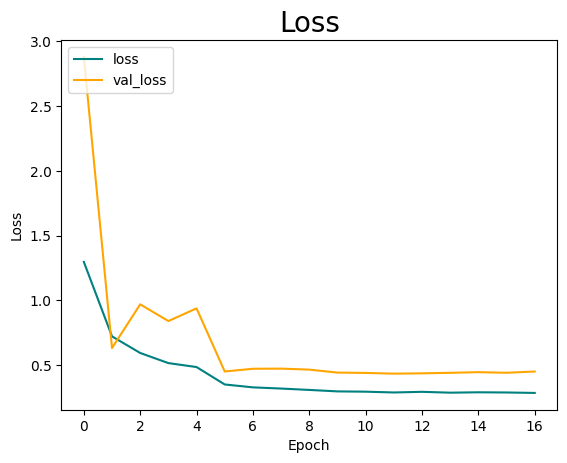

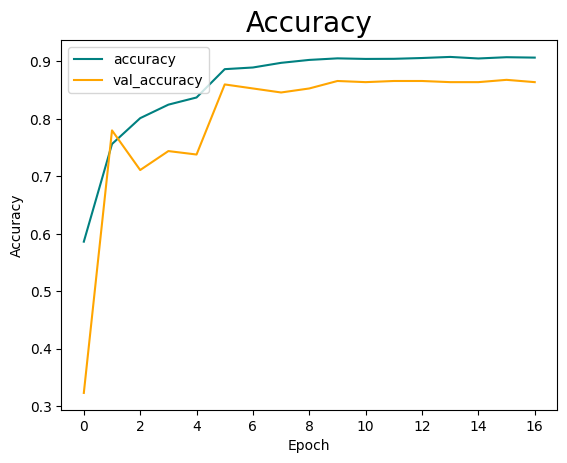

    Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
16     17          0.9067         0.864     0.28399  0.449556   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
16          0.92729       0.881865        0.8889       0.851          0.9067   

    Val F1-score  Train AUC   Val AUC  
16         0.864   0.994863  0.986498  


In [67]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),
    
        # Augmentation
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3, 3),  padding='valid', strides = (2, 2), 
                               kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
        # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2),  
                               kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
        # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2), 
                               kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
        # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')  
    ])
    return model

for opt in optimizers:
    model_4 = build_model()
    model_4 = cnn.compile(model_4, opt)
    history_m4 = cnn.train(model_4, train_ds, val_ds, [early_stoping, reduce_lr], epochs=20)    # changes
    cnn.plot_performance(history_m4)
    metrics_m4_df = cnn.metrics_performance(history_m4)
    print(metrics_m4_df[-1:])

>**Results in the last epoch:** 
>
> **RMSprop:**
> - noticeable gap between validation and training sets
> - overfitting
> - train accuracy: 93%, val accuracy: 90%
> - loss: 0.34
> - precision: 0.94
> - recall: 0.92
> - f1_score: 0.90
> - auc: 0.98
>
> **SGD:**
> - validation and training sets' curves showed apprixamately the same convergence
> - train accuracy: 90%, val accuracy: 91%
> - loss: 0.27
> - precision: 0.92
> - recall: 0.89
> - f1_score: 0.91
> - auc: 0.99
>
>  **Adam:**
> - stabilized by the last epochs
> - overfitting
> - low accuracy
> - train accuracy: 90%, val accuracy: 86%
> - loss: 0.44
> - precision: 0.88
> - recall: 0.84
> - f1_score: 0.86
> - auc: 0.98

In conclusion, with the optimizer Adam the model performed the worst, with the accuracy 90% and loss of 0.44. In contrast to whis, SDG optimizer significantly impoved the model's performance, solving the overfitting problem. Additionally, AUC is almost perferct (0.99), indicating that model has a solid performance.

### Final Model
> - Three Conv2D layers
> - Data Augmentation layers
> - BatchNorm layer
> - Dropout Layer (0.2)

> - L2 regularization (l_r = 0.001)
> - padding = 'valid'
> - strides = 2
> - optimizer = 'sgd'

In [ ]:
# tensorboard --logdir=runs

In [ ]:
from tensorflow.keras.callbacks import TensorBoard 

In [72]:
log_dir = '/logs'
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [73]:
# from tensorflow.keras.callbacks import TensorBoard 

# log_dir = r'C:\Users\eliza\logs\fit'
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [74]:
model_final = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),

    # Augmentation
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, (3, 3),  padding='valid', strides = (2, 2), 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2),  
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3),  padding='valid', strides = (2, 2), 
                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.0001)), # changes
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model_final = cnn.compile(model_final, keras.optimizers.SGD())
history_final = cnn.train(model_final, train_ds, val_ds, [early_stoping, reduce_lr, tb_callback], epochs=100)    

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 187ms/step - accuracy: 0.3865 - auc: 0.7897 - f1_score: 0.3865 - loss: 1.7727 - precision: 0.6189 - recall: 0.1948 - val_accuracy: 0.3950 - val_auc: 0.8734 - val_f1_score: 0.3950 - val_loss: 1.6501 - val_precision: 0.4641 - val_recall: 0.3430 - learning_rate: 0.0100
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.6999 - auc: 0.9583 - f1_score: 0.6999 - loss: 0.8643 - precision: 0.7913 - recall: 0.6060 - val_accuracy: 0.7430 - val_auc: 0.9637 - val_f1_score: 0.7430 - val_loss: 0.8002 - val_precision: 0.7977 - val_recall: 0.6820 - learning_rate: 0.0100
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - accuracy: 0.7516 - auc: 0.9697 - f1_score: 0.7516 - loss: 0.7274 - precision: 0.8200 - recall: 0.6849 - val_accuracy: 0.8050 - val_auc: 0.9771 - val_f1_score: 0.8050 - val_loss: 0.6212 - val_precision: 0.8484 - val_recall: 0.7720 - learning_rate: 0.0100
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accura

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_10 (RandomRotation)  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_10 (RandomZoom)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 128, 128, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 63, 63, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,901,592 (7.25 MB)

 Trainable params: 1,901,264 (7.25 MB)

 Non-trainable params: 326 (1.27 KB)

 Optimizer params: 2 (12.00 B)

None


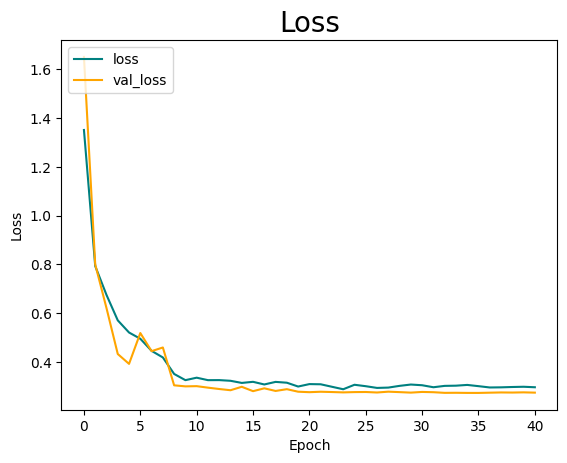

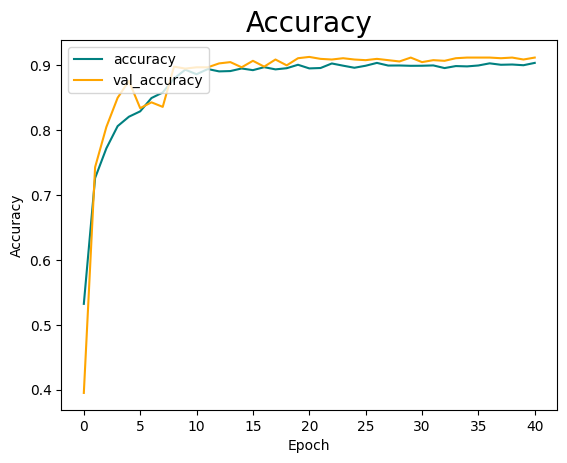

In [76]:
cnn.plot_performance(history_final)

In [80]:
cnn.metrics_performance(history_final)[-1:]

Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss  \
40     41          0.9038         0.912    0.297003  0.274922   

    Train Precision  Val Precision  Train Recall  Val Recall  Train F1-score  \
40         0.922179       0.928571        0.8852       0.897          0.9038   

    Val F1-score  Train AUC   Val AUC  
40         0.912    0.99447  0.994532

In [81]:
%reload_ext tensorboard

In [82]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 27592), started 13:16:04 ago. (Use '!kill 27592' to kill it.)

In [83]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

## Evaluating & Testing

In [84]:
loss, accuracy, precision, recall, auc, f1 = cnn.evaluate(model_final, val_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8927 - auc: 0.9943 - f1_score: 0.8927 - loss: 0.3080 - precision: 0.9083 - recall: 0.8802

|Accuracy: 0.9120000004768372
|Loss: 0.2737641930580139
|Precision: 0.9285714030265808
|Recall: 0.8970000147819519
|AUC: 0.9945383667945862
|F1: 0.9119999408721924



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Number of incorrect labels: 1 / 32


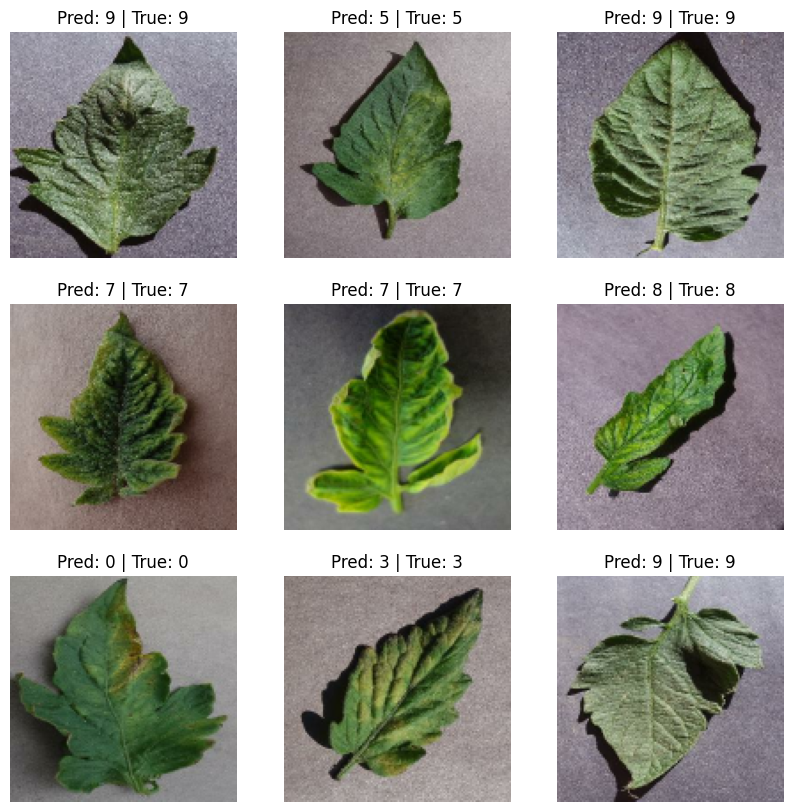

In [88]:
for image_batch, label_batch in val_ds.take(1):
    pred = cnn.prediction(model_final, image_batch)
    inc_lab = [i for i in range(len(label_batch)) if np.argmax(label_batch[i]) != pred[i]]
    print(f'\nNumber of incorrect labels: {len(inc_lab)} / {len(label_batch)}')
    
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i])
        plt.title(f'Pred: {pred[i]} | True: {np.argmax(label_batch[i], axis=-1)}')
        plt.axis('off')
plt.show()

# Save the model

In [211]:
from tensorflow.keras.models import load_model
import cv2

In [99]:
model_cnn = model_final.save(os.path.join('models', 'cnn_tomat_leaves.h5'))

# Comparison with MLP model 

In [189]:
from sklearn.neural_network import MLPClassifier

In [221]:
data_dir = pathlib.Path(r'C:\Users\eliza\.kaggle\tomatoleaf\tomato')

In [222]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / 'train', 
    # validation_split = 0.3,
    # subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / 'val',
    # validation_split = 0.3,
    # subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [223]:
X_train = []
y_train = []

for img, label in train_ds:
    X_train.append(img.numpy())
    y_train.append(label.numpy()) # encode

print(f"Train Data: {len(X_train)}, {len(y_train)}")

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

Train Data: 313, 313


In [224]:
X_val = []
y_val = []

for img, label in val_ds:
    X_val.append(img.numpy())
    y_val.append(label.numpy()) # encodez

print(f"Val Data: {len(X_val)}, {len(y_val)}")

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

Val Data: 32, 32


In [225]:
type(X_train)

numpy.ndarray

In [240]:
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Val Data: {X_val.shape}, {y_val.shape}")

Train Data: (10000, 128, 128, 3), (10000,)
Val Data: (1000, 128, 128, 3), (1000,)


In [241]:
X_train_color = X_train.reshape((X_train.shape[0], -1))
X_val_color = X_val.reshape((X_val.shape[0], -1))

In [242]:
print(f"Train Data: {X_train_color.shape}, {y_train.shape}")
print(f"Val Data: {X_val_color.shape}, {y_val.shape}")

Train Data: (10000, 49152), (10000,)
Val Data: (1000, 49152), (1000,)


In [243]:
# normalizing
X_train_color = X_train_color /255.0
X_val_color = X_val_color /255.0

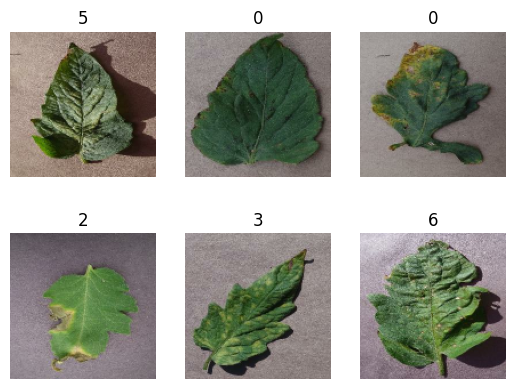

In [244]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train_color[i].reshape(128,128,3))
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [233]:
mlp_color = MLPClassifier(random_state=1, max_iter=300).fit(X_train_color, y_train)

In [235]:
pred = mlp_color.predict(X_val_color)
print(mlp_color.score(X_val_color, y_val))

0.502


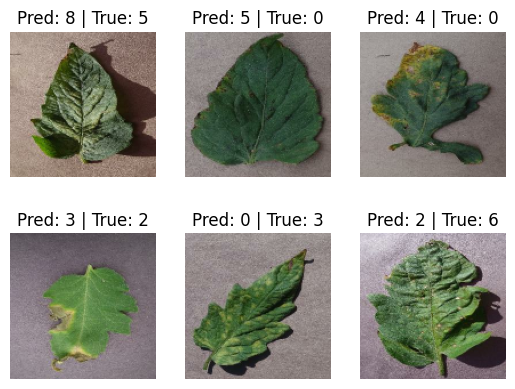

In [246]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train_color[i].reshape(128,128, 3))
    plt.title(f'Pred: {pred[i]} | True: {y_train[i]}')
    plt.axis('off')
plt.show()

The mlp model from sklearn gave accuraccy = 0.502, which is the dramatically low score. In order to see the difference with grey / colored datasets, we will run model with the greyscaled photos.

In [247]:
# convert to gray
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])
X_val_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_val])

In [248]:
X_train_gray = X_train_gray.reshape((X_train_gray.shape[0], -1))
X_val_gray = X_val_gray.reshape((X_val_gray.shape[0], -1))

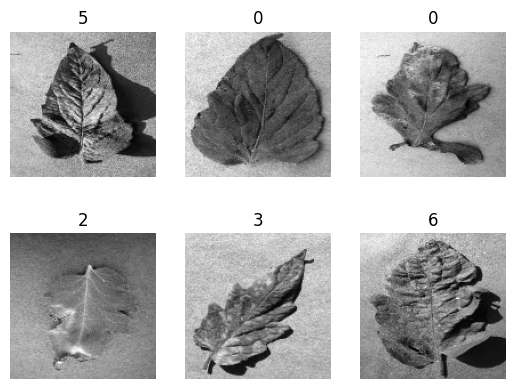

In [249]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train_gray[i].reshape(128,128), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [250]:
mlp_grey = MLPClassifier(random_state=1, max_iter=300).fit(X_train_gray, y_train)

In [255]:
pred = mlp_grey.predict(X_val_gray)
print(mlp_grey.score(X_val_gray, y_val))

0.105


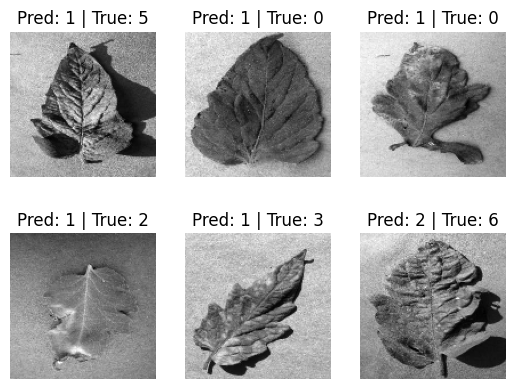

In [254]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train_gray[i].reshape(128,128), cmap='gray')
    plt.title(f'Pred: {pred[i]} | True: {y_train[i]}')
    plt.axis('off')
plt.show()

Thee accuracy remained being low, at 0.105. Consequently, Convolutional Neural Networks works significanyly better fot the image classification tasks.